# Smart Document Retrieval System for Reuters Corpus

This script implements an information retrieval system using OpenSearch (compatible with Elasticsearch) for indexing and querying documents from the Reuters corpus. It extracts temporal expressions using dateparser and georeferences using spaCy and Geopy. The system supports textual, spatiotemporal queries, autocomplete, and analytics such as top georeferences and temporal distributions.

Key Components:
- Document parsing and cleaning from SGML files.
- Entity extraction: temporal expressions and georeferences (with normalization to countries and geocoding).
- Embedding generation for semantic search using Sentence Transformers.
- Indexing with custom mappings for efficient search, including autocomplete, stemming, and KNN for vectors.
- Query functions: lexical, semantic, hybrid with re-ranking (title emphasis, recency, localization).
- Analytics: top georeferences, document distribution over time.
- Autocomplete for titles with fuzziness for misspellings.

Dependencies: opensearch-py, spacy (en_core_web_md), dateparser, geopy, bs4, lxml, tqdm, sentence-transformers, beautifulsoup4.

In [ ]:
# Install dependencies (run once)
# -------------------------
# !pip install opensearch-py spacy dateparser geopy bs4 lxml tqdm sentence-transformers beautifulsoup4
# !python -m spacy download en_core_web_md

In [ ]:
# Imports
# -------------------------
import os, re, json, glob, time
from bs4 import BeautifulSoup
import spacy
import dateparser
from dateparser.search import search_dates
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
from opensearchpy import OpenSearch
from opensearchpy.helpers import bulk
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import numpy as np
from geopy.distance import geodesic
from datetime import datetime, timedelta


ModuleNotFoundError: No module named 'bs4'

# Settings

In [ ]:

DATA_PATH = "../data/reut2-000.sgm"
EMBEDDING_CACHE = "embeddings.json"
GEOCACHE_FILE = "geocache.json"
NORMALIZATION_CACHE_FILE = "norm_geocache.json"
INDEX_NAME = "top_queries-2025.12.14-15395"
BATCH_SIZE = 300


# Connect OpenSearch

In [ ]:

client = OpenSearch(
    hosts=[{"host": "localhost", "port": 9200}],
    http_compress=True,
    use_ssl=False,
    verify_certs=False
)
print("OpenSearch info:", client.info()["version"]["number"])


OpenSearch info: 3.3.2


# Utilities

In [ ]:

def clean_text(html_content):
    soup = BeautifulSoup(html_content or "", "lxml")
    text = soup.get_text(separator=" ", strip=True)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()


# Load embedding model + cache

In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2")
try:
    with open(EMBEDDING_CACHE, "r", encoding="utf-8") as f:
        embedding_cache = json.load(f)
except FileNotFoundError:
    embedding_cache = {}

def get_embedding_cached(text):
    key = text.strip()
    if not key: return [0.0]*384
    if key in embedding_cache:
        return embedding_cache[key]
    emb = model.encode(text).tolist()
    embedding_cache[key] = emb
    with open(EMBEDDING_CACHE, "w", encoding="utf-8") as f:
        json.dump(embedding_cache, f)
    return emb

# Load spaCy model

In [ ]:
nlp = spacy.load("en_core_web_md")

# Geopy setup + Extract georeferences + Temporal extraction

In [ ]:
# Geopy setup
geolocator = Nominatim(user_agent="smart_doc_system")

# Load caches
try:
    with open(GEOCACHE_FILE, "r", encoding="utf-8") as f:
        geocache = json.load(f)
except FileNotFoundError:
    geocache = {}

try:
    with open(NORMALIZATION_CACHE_FILE, "r", encoding="utf-8") as f:
        norm_cache = json.load(f)
except FileNotFoundError:
    norm_cache = {}

def save_cache(cache, path):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(cache, f, indent=2)

# -------------------------
# Geocode a location with caching
# -------------------------
def geocode_cached(location_name, max_retries=3, delay=1):
    if not location_name: return None
    key = location_name.strip().lower()
    if key in geocache: return geocache[key]

    for attempt in range(max_retries):
        try:
            loc = geolocator.geocode(location_name, timeout=10)
            if loc:
                result = {"lat": loc.latitude, "lon": loc.longitude, "address": loc.address}
                geocache[key] = result
                save_cache(geocache, GEOCACHE_FILE)
                time.sleep(delay)
                return result
            else:
                geocache[key] = None
                save_cache(geocache, GEOCACHE_FILE)
                return None
        except (GeocoderTimedOut, GeocoderUnavailable):
            time.sleep(delay)
        except Exception as e:
            print(f"Error geocoding '{location_name}': {e}")
            geocache[key] = None
            save_cache(geocache, GEOCACHE_FILE)
            return None
    return None

# -------------------------
# Normalize location to country
# -------------------------
def normalize_location(location_name, max_retries=3, delay=1):
    if not location_name: return location_name
    key = location_name.strip().lower()
    if key in norm_cache: return norm_cache[key]

    loc = geocode_cached(location_name, max_retries=max_retries, delay=delay)
    if not loc:
        norm_cache[key] = location_name
        save_cache(norm_cache, NORMALIZATION_CACHE_FILE)
        return location_name

    for attempt in range(max_retries):
        try:
            reverse = geolocator.reverse((loc["lat"], loc["lon"]), language="en", timeout=10)
            country = reverse.raw.get("address", {}).get("country") if reverse else None
            if country:
                norm_cache[key] = country
                save_cache(norm_cache, NORMALIZATION_CACHE_FILE)
                time.sleep(delay)
                return country
        except (GeocoderTimedOut, GeocoderUnavailable):
            time.sleep(delay)
        except Exception:
            break
    norm_cache[key] = location_name
    save_cache(norm_cache, NORMALIZATION_CACHE_FILE)
    return location_name

# -------------------------
# Extract georeferences
# -------------------------
def extract_georeferences(text, places_from_sgml=None):
    geo_names = set()
    geo_points = []

    # SGML <PLACES>
    if places_from_sgml:
        for p in places_from_sgml:
            if not p: continue
            loc = geocode_cached(p)
            if loc:
                geo_points.append({"lat": loc["lat"], "lon": loc["lon"]})
                country = normalize_location(p)
                geo_names.add(country if country else p)
            else:
                geo_names.add(p)

    # spaCy NER
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ not in ("GPE", "LOC"): continue
        name = ent.text.strip()
        if len(name) < 3 or name.isdigit() or re.search(r"\d", name): continue
        loc = geocode_cached(name)
        country = normalize_location(name)
        geo_names.add(country if country else name)
        if loc:
            geo_points.append({"lat": loc["lat"], "lon": loc["lon"]})

    return list(geo_names), geo_points

# -------------------------
# Temporal extraction
# -------------------------
def extract_temporal(text):
    results = search_dates(
        text,
        settings={'PREFER_DATES_FROM':'past', 'RELATIVE_BASE':datetime(1987,1,1)}
    )
    if results:
        return [dt.isoformat() for _, dt in results]
    return []


# Mapping + loading documents + indexing 

In [ ]:
# ElasticSearch Mapping

mapping = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0,
        "index": {"knn": True},
        "analysis": {
            "filter": {
                "edge_ngram_filter": {"type": "edge_ngram", "min_gram":3, "max_gram":20},
                "english_stop": {"type": "stop", "stopwords":"_english_"},
                "english_stemmer": {"type":"stemmer","name":"english"}
            },
            "analyzer": {
                "autocomplete":{"type":"custom","tokenizer":"standard","filter":["lowercase","edge_ngram_filter"]},
                "content_analyzer":{"type":"custom","tokenizer":"standard","filter":["lowercase","english_stop","english_stemmer"]}
            }
        }
    },
    "mappings": {
        "properties": {
            "title":{"type":"text","analyzer":"autocomplete","search_analyzer":"standard"},
            "content":{"type":"text","analyzer":"content_analyzer"},
            "content_vector":{"type":"knn_vector","dimension":384},
            "authors":{"type":"nested","properties":{"first_name":{"type":"text"},"last_name":{"type":"text"},"email":{"type":"keyword"}}},
            "date":{"type":"date"},
            "geopoint":{"type":"geo_point"},
            "temporal_expressions":{"type":"date"},
            "georeferences":{"type":"geo_point"},
            "georeference_names":{"type":"keyword"}
        }
    }
}

# Load & parse SGML Reuters files
def load_documents(path_glob):
    files = glob.glob(path_glob)
    print("Found:", len(files), "files")
    doc_counter = 1
    for file_path in files:
        with open(file_path, "r", encoding="latin-1", errors="ignore") as f:
            soup = BeautifulSoup(f, "lxml")
            
            for reuters in soup.find_all("reuters"):
                doc_id = str(doc_counter)
                doc_counter += 1

                # Title
                title_tag = reuters.find("title")
                title = title_tag.get_text(strip=True) if title_tag else ""

                # -----------------------------
                # Robust Body Extraction (FIXED PART)
                # -----------------------------
                text_tag = reuters.find("text")
                body = ""
                if text_tag:
                    # Remove author tag first so it doesn't leak into body
                    author_tag = text_tag.find("author")
                    if author_tag:
                        author_tag.decompose()  # safely remove it

                    # Get ALL text inside <TEXT>, with spaces instead of newlines
                    raw_text = text_tag.get_text(separator=" ", strip=False)

                    # Clean up Reuters noise:
                    # - Remove control codes like &#3;, &#5;, &#22;
                    # - Remove terminal garbage like RM, f0403, reute, etc.
                    # - Normalize whitespace
                    cleaned = re.sub(r'&#\d+;', ' ', raw_text)                # &#3; → space
                    cleaned = re.sub(r'\bRM\b|\bf\d{4}\b|\breute\b', ' ', cleaned, flags=re.IGNORECASE)
                    cleaned = re.sub(r'\s+', ' ', cleaned)                    # collapse whitespace
                    cleaned = re.sub(r'\s+REUTER[S]?\s*$', '', cleaned, flags=re.IGNORECASE)  # trailing REUTER
                    cleaned = cleaned.strip()

                    # Optional: if body is too short, skip (avoids empty docs)
                    if len(cleaned.split()) < 5:  # less than ~5 words → probably junk
                        continue

                    body = cleaned

                if not body:
                    continue  # skip documents with no body

                # Explicit date from <DATE> tag
                date_tag = reuters.find("date")
                explicit_date = None
                if date_tag and date_tag.get_text(strip=True):
                    explicit_date = dateparser.parse(
                        date_tag.get_text(strip=True),
                        settings={"PREFER_DATES_FROM": "past", "RELATIVE_BASE": datetime(1987, 1, 1)}
                    )

                # Places from <PLACES><D>...
                places = []
                places_tag = reuters.find("places")
                if places_tag:
                    for d in places_tag.find_all("d"):
                        txt = d.get_text(strip=True)
                        if txt:
                            places.append(txt)

                # -----------------------------
                # Authors extraction (kept as-is, it's good)
                # -----------------------------
                authors = []
                author_tag = text_tag.find("author") if text_tag else None
                if author_tag and author_tag.get_text(strip=True):
                    author_text = author_tag.get_text(strip=True).strip()

                    cleaned = author_text
                    if cleaned.lower().startswith("by "):
                        cleaned = cleaned[3:].strip()

                    cleaned = re.sub(r",\s*Reuters\)?$", "", cleaned, flags=re.IGNORECASE).strip()
                    cleaned = re.sub(r"\s*\(Reuters\)$", "", cleaned, flags=re.IGNORECASE).strip()

                    email = ""
                    email_match = re.search(r'[<\(]([^@\s]+@[^@\s\)>]+)[>\)]', cleaned)
                    if email_match:
                        email = email_match.group(1).strip().lower()
                        cleaned = re.sub(r'[<\(][^@\s]+@[^@\s\)>]+[>\)]', '', cleaned).strip()

                    cleaned = re.sub(r'\s+', ' ', cleaned).strip()

                    name_parts = cleaned.split()
                    if len(name_parts) >= 2:
                        first_name = name_parts[0]
                        last_name = " ".join(name_parts[1:])
                    elif len(name_parts) == 1:
                        first_name = name_parts[0]
                        last_name = ""
                    else:
                        first_name = "Unknown"
                        last_name = "Author"

                    authors.append({
                        "first_name": first_name,
                        "last_name": last_name,
                        "email": email
                    })
                else:
                    authors.append({
                        "first_name": "Unknown",
                        "last_name": "Author",
                        "email": ""
                    })

                yield doc_id, title, body, authors, explicit_date, places

# Document -> index action

def doc_to_action(doc_id, title, content, authors, explicit_date=None, places=None):
    if places is None:
        places = []
    
    full_text = (title or "") + " " + (content or "")
    
    cleaned_content = clean_text(content)
    vector = get_embedding_cached(cleaned_content)

    temporal = extract_temporal(full_text)

    date_val = None
    if explicit_date:
        try:
            date_val = explicit_date.isoformat()
        except Exception:
            date_val = None
    else:
        parsed_dates = []
        for t in temporal:
            try:
                dt = dateparser.parse(
                    t,
                    settings={"PREFER_DATES_FROM": "past", "RELATIVE_BASE": datetime(1987, 1, 1)}
                )
                if dt:
                    parsed_dates.append(dt)
            except Exception:
                pass
        if parsed_dates:
            date_val = min(parsed_dates).isoformat()

    geo_names, geo_points = extract_georeferences(full_text, places)
    
    #if not places and geo_names and geo_names != ['UNKNOWN']:
       # print(f"Document {doc_id} had no SGML <PLACES>, but extracted {geo_names} from text")

    if not geo_names:
        geo_names = ['UNKNOWN']
    
    if not geo_points:
        default_point = {"lat": 0.0, "lon": 0.0}
        geo_points = [default_point]
    
    geopoint = geo_points[0]

    body = {
        "title": title,
        "content": content,
        "content_vector": vector,
        "authors": authors,
        "date": date_val,
        "temporal_expressions": temporal,
        "georeferences": geo_points,
        "georeference_names": geo_names,
        "geopoint": geopoint,
        "original_sgml_places": places
    }

    return {
        "_op_type": "index",
        "_index": INDEX_NAME,
        "_id": doc_id,
        "_source": body
    }


# Bulk index

def bulk_index(path_glob, batch_size=BATCH_SIZE):
    actions=[]
    total=0
    for doc_id, title, content, authors, explicit_date, places in load_documents(path_glob):
        action = doc_to_action(doc_id, title, content, authors, explicit_date, places)
        actions.append(action)
        if len(actions)>=batch_size:
            try:
                success, errors = bulk(client, actions)
                total += success
                print(f"Indexed batch: {success}, total: {total}")
                if errors: print("Batch errors:", errors)
            except Exception as e:
                print("Bulk error:", e)
            actions=[]
    if actions:
        try:
            success, errors = bulk(client, actions)
            total += success
            print(f"Indexed final batch: {success}, total: {total}")
            if errors: print("Final batch errors:", errors)
        except Exception as e:
            print("Final bulk error:", e)
    print("Bulk indexing completed. Total indexed:", total)
    return total


NameError: name 'BATCH_SIZE' is not defined

# Searches and helpers

In [ ]:

def lexical_search(query_text, size=10):
    body = {"size": size, "query": {"multi_match": {"query": query_text, "fields": ["title^3", "content"]}}}
    return client.search(index=INDEX_NAME, body=body)

def semantic_search(query_text, size=10):
    query_vector = get_embedding_cached(query_text)
    query_vector = [float(x) for x in query_vector]

    body = {
        "size": size,
        "query": {
            "knn": {
                "content_vector": {
                    "vector": query_vector,
                    "k": size
                }
            }
        }
    }
    return client.search(index=INDEX_NAME, body=body)


def smart_hybrid_search(
    query_tuple,  # Tuple: (query_text, start_date, end_date, georeference)
    size: int = 10
 ):
    """
    Hybrid search with lexical + semantic retrieval, strong title emphasis,
    date range filtering (calendar picker style), geo preference,
    and final re-ranking by title, recency, and geographic proximity.

    - start_date / end_date: str (YYYY-MM-DD), datetime, date, or None
    - If end_date is None → defaults to December 31 of the start_date's year
    - If both None → no date filtering
    """
    if not isinstance(query_tuple, tuple) or len(query_tuple) != 4:
        raise ValueError("Query must be a tuple: (query_text, start_date, end_date, georeference)")

    query_text, start_date_input, end_date_input, georef = query_tuple

    # Helper to convert various date inputs to datetime
    def to_datetime(obj):
        if obj is None:
            return None
        if isinstance(obj, str):
            return datetime.fromisoformat(obj.split('T')[0])
        if isinstance(obj, (datetime, datetime.date)):
            return datetime.combine(obj.date() if hasattr(obj, 'date') else obj, datetime.min.time())
        raise ValueError(f"Unsupported date type: {type(obj)}")

    start = to_datetime(start_date_input)
    end = to_datetime(end_date_input)

    # NEW: If end_date is None, default to Dec 31 of the year (based on start_date or current year)
    if end is None:
        if start:
            year = start.year
        else:
            year = datetime.now().year  # fallback if no start date
        end = datetime(year, 12, 31, 23, 59, 59)

    # Validate order
    if start and end and start > end:
        raise ValueError("start_date cannot be after end_date")

    # Build Elasticsearch date range filter
    date_range = {}
    if start:
        date_range["gte"] = start.date().isoformat()
    if end:
        # Inclusive end: up to end of day on Dec 31 (or specified end)
        date_range["lte"] = (end.date() + timedelta(days=1) - timedelta(seconds=1)).isoformat()

    range_filter = {"range": {"date": date_range}} if date_range else None

# Georeference → lat/lon
lat = lon = None
if georef and georef.strip():
    g = georef.strip()

    # CASE 1: coordinates from front-end "lat,lon"
    if "," in g:
        try:
            lat, lon = map(float, g.split(","))
        except ValueError:
            lat = lon = None

    # CASE 2: place name (existing behavior)
    if lat is None or lon is None:
        loc = geocode_cached(g)
        if loc:
            lat, lon = loc["lat"], loc["lon"]
        elif "usa" in g.lower():
            lat, lon = 39.8283, -98.5795  # USA center

    query_point = (lat, lon) if lat is not None and lon is not None else None

    # 1. Lexical search (title heavily boosted + date filter)
    lex_body = {
        "size": 50,
        "query": {
            "bool": {
                "must": [{"multi_match": {"query": query_text, "fields": ["title^5", "content"]}}],
                "filter": [range_filter] if range_filter else []
            }
        }
    }
    lex_results = client.search(index=INDEX_NAME, body=lex_body)

    # 2. Semantic search (no date filter in ES)
    query_vector = [float(x) for x in get_embedding_cached(query_text)]
    sem_body = {
        "size": 100,
        "query": {"knn": {"content_vector": {"vector": query_vector, "k": 100}}}
    }
    sem_results = client.search(index=INDEX_NAME, body=sem_body)

    # 3. Combine candidates + manual date filter on semantic results
    candidates = {}
    for hit in lex_results["hits"]["hits"]:
        doc_id = hit["_id"]
        candidates[doc_id] = {
            "hit": hit,
            "source": hit["_source"],
            "score": hit["_score"],
            "lexical_score": hit["_score"],
            "semantic_score": 0.0
        }

    for hit in sem_results["hits"]["hits"]:
        source = hit["_source"]
        date_str = source.get("date")

        # Manual date filtering for semantic hits
        if date_range and date_str:
            try:
                doc_date = datetime.fromisoformat(date_str.replace("Z", "+00:00").split('+')[0])
                if start and doc_date.date() < start.date():
                    continue
                if end and doc_date.date() > end.date():
                    continue
            except:
                continue
        elif date_range and not date_str:
            continue

        doc_id = hit["_id"]
        sem_score = hit["_score"]
        if doc_id in candidates:
            candidates[doc_id]["semantic_score"] = sem_score
            candidates[doc_id]["score"] += sem_score
        else:
            candidates[doc_id] = {
                "hit": hit,
                "source": source,
                "score": sem_score,
                "lexical_score": 0.0,
                "semantic_score": sem_score
            }

    # 4. Final re-ranking
    now = datetime(1987, 12, 31)  # Adjust this if your index covers multiple years
    query_words = query_text.lower().split()

    ranked = []
    for info in candidates.values():
        source = info["source"]
        final_score = info["score"]

        # Strong title boost
        title_lower = source.get("title", "").lower()
        title_matches = sum(1 for w in query_words if w in title_lower.split())
        if title_matches:
            final_score *= (1 + title_matches * 2.5)

        # Recency boost
        date_str = source.get("date")
        if date_str:
            try:
                doc_date = datetime.fromisoformat(date_str.replace("Z", "+00:00").split('+')[0])
                months_old = max(0, (now - doc_date).days // 30)
                final_score *= max(0.5, 1 - months_old * 0.02)
            except:
                pass

        # Geographic proximity boost
        if query_point:
            gp = source.get("geopoint", {})
            dlat, dlon = gp.get("lat"), gp.get("lon")
            if dlat is not None and dlon is not None:
                try:
                    dist_km = geodesic(query_point, (dlat, dlon)).km
                    final_score *= max(0.1, 10 ** (-dist_km / 10000))
                except:
                    pass

        ranked.append((info["hit"], final_score))

    ranked.sort(key=lambda x: x[1], reverse=True)
    top_hits = [hit for hit, _ in ranked[:size]]

    return {"hits": {"hits": top_hits}}


    """
    Hybrid search (lexical + semantic) with manual re-ranking for:
    - Title matches (higher weight)
    - Recency (newer = better)
    - Localization (closer = better)
    """
    # 1. Run lexical search (title^5 for stronger title boost)
    lex_results = lexical_search(query_text, size=50)  # get more candidates
    
    # 2. Run semantic search
    sem_results = semantic_search(query_text, size=50)
    
    # 3. Combine all unique hits with initial scores
    candidates = {}
    
    for hit in lex_results['hits']['hits']:
        doc_id = hit['_id']
        score = hit['_score']
        source = hit['_source']
        candidates[doc_id] = {
            'hit': hit,
            'score': score,
            'source': source,
            'lexical_score': score,
            'semantic_score': 0.0
        }
    
    for hit in sem_results['hits']['hits']:
        doc_id = hit['_id']
        score = hit['_score']
        source = hit['_source']
        if doc_id in candidates:
            candidates[doc_id]['semantic_score'] = score
            candidates[doc_id]['score'] += score  # add semantic boost
        else:
            candidates[doc_id] = {
                'hit': hit,
                'score': score,
                'source': source,
                'lexical_score': 0.0,
                'semantic_score': score
            }
    
    # 4. Manual re-ranking with three factors
    now = datetime.now()
    query_point = (lat, lon) if lat is not None and lon is not None else None
    
    ranked = []
    for doc_id, info in candidates.items():
        source = info['source']
        base_score = info['score']
        
        final_score = base_score
        
        # Factor 1: Title boost (if query words appear in title)
        title = source.get('title', '').lower()
        query_lower = query_text.lower()
        title_words_matched = sum(1 for word in query_lower.split() if word in title)
        if title_words_matched > 0:
            final_score *= (1 + title_words_matched * 1.5)  # strong title boost
        
          # Factor 2: Recency boost (monthly step, soft)
        date_str = source.get('date')
        if date_str:
            try:
                doc_date = datetime.fromisoformat(date_str.replace('Z', '+00:00'))
                days_old = (now - doc_date).days
                months_old = days_old // 30  # full months
                
                MONTHLY_PENALTY = 0.03  # 3% penalty per month
                MIN_BOOST = 0.5         # minimum boost
                
                recency_boost = max(MIN_BOOST, 1 - months_old * MONTHLY_PENALTY)
                final_score *= recency_boost
            except:
                pass
        
        # Factor 3: Localization boost (if query location provided)
        if query_point:
            geopoint = source.get('geopoint', {})
            doc_lat = geopoint.get('lat')
            doc_lon = geopoint.get('lon')
            if doc_lat is not None and doc_lon is not None:
                doc_point = (doc_lat, doc_lon)
                try:
                    distance_km = geodesic(query_point, doc_point).kilometers
                    # Closer = higher boost (max at 0km, decays over 5000km)
                    proximity_boost = max(0.05, 10 ** (-distance_km / 10000))                   
                    final_score *= proximity_boost
                except:
                    pass
        
        ranked.append((info['hit'], final_score))
    
    # 5. Sort by final score and return top N
    ranked.sort(key=lambda x: x[1], reverse=True)
    top_hits = [hit for hit, score in ranked[:size]]
    
    return {
        "hits": {
            "hits": top_hits
        }
    }
def autocomplete_titles(prefix, size=10):
    if len(prefix) < 3:
        return []
    q = {
        "_source": ["title"],
        "size": size,
        "query": {
            "bool": {
                "should": [
                    {"match_phrase_prefix": {"title": {"query": prefix}}},
                    {"match": {"title": {"query": prefix, "fuzziness": "AUTO", "prefix_length": 2}}}
                ]
            }
        }
    }
    res = client.search(index=INDEX_NAME, body=q)
    seen = set()
    titles = []
    for hit in res["hits"]["hits"]:
        t = hit["_source"].get("title","").strip()
        if t and t not in seen:
            titles.append(t)
            seen.add(t)
        if len(titles) >= size:
            break
    return titles

def spatio_temporal_search(text=None, start=None, end=None, country=None, lat=None, lon=None, radius_km=50, size=10):
    must = []
    if text:
        must.append({"multi_match": {"query": text, "fields": ["title^3", "content"]}})
    if start or end:
        rng = {}
        if start: rng["gte"] = start
        if end: rng["lte"] = end
        must.append({"range": {"date": rng}})
    if country:
        must.append({"term": {"georeference_names.keyword": country}})
    if lat is not None and lon is not None:
        must.append({"geo_distance": {"distance": f"{radius_km}km", "geopoint": {"lat": lat, "lon": lon}}})

    body = {"size": size, "query": {"bool": {"must": must or [{"match_all": {}}]}}}
    return client.search(index=INDEX_NAME, body=body)


    query_vector = [float(x) for x in get_embedding_cached(query_text)]

    base_queries = [
        {"multi_match": {"query": query_text, "fields": ["title^5", "content"]}},
        {"knn": {"field": "content_vector", "query_vector": query_vector, "k": size, "num_candidates": 100}}
    ]

    functions = [
        {
            "gauss": {
                "date": {
                    "origin": "now",
                    "scale": "365d",
                    "decay": 0.9   # Keeps newer docs strongly boosted
                }
            }
        }
    ]

    if lat is not None and lon is not None:
        functions.append(
            {
                "gauss": {
                    "geopoint": {
                        "origin": {"lat": lat, "lon": lon},
                        "scale": "2000km",
                        "decay": 0.8
                    }
                }
            }
        )

    body = {
        "size": size,
        "query": {
            "function_score": {
                "query": {"bool": {"should": base_queries}},
                "functions": functions,
                "boost_mode": "multiply",
                "score_mode": "multiply"
            }
        },
        "_source": ["title", "content", "date", "georeference_names", "geopoint"]
    }
    return client.search(index=INDEX_NAME, body=body)
    query_vector = [float(x) for x in get_embedding_cached(query_text)]

    base_queries = [
        {"multi_match": {"query": query_text, "fields": ["title^5", "content"]}},  # Title weighted 5x higher
        {"knn": {"field": "content_vector", "query_vector": query_vector, "k": size, "num_candidates": 100}}
    ]

    # Always start with a list containing recency boost
    functions = [
        {
            "gauss": {
                "date": {
                    "origin": "now",
                    "scale": "365d",
                    "decay": 0.9
                }
            }
        }
    ]

    # Add localization boost only if location provided
    if lat is not None and lon is not None:
        functions.append({
            "gauss": {
                "geopoint": {
                    "origin": {"lat": lat, "lon": lon},
                    "scale": "2000km",
                    "decay": 0.8
                }
            }
        })

    body = {
        "size": size,
        "query": {
            "function_score": {
                "query": {"bool": {"should": base_queries}},
                "functions": functions,           # Now always a proper list
                "boost_mode": "multiply",
                "score_mode": "multiply"
            }
        },
        "_source": ["title", "content", "date", "georeference_names", "geopoint"]
    }
    return client.search(index=INDEX_NAME, body=body)


In [ ]:

# Run ingest + FULL TESTS
# -------------------------
if __name__ == "__main__":
    print("Starting bulk ingest from:", DATA_PATH)
    bulk_index(DATA_PATH)

  


Starting bulk ingest from: ./data/reut2-000.sgm
Found: 1 files


In [ ]:
def analytics_top_georefs_and_timeline(size=10):
    body = {
        "size": 0,
        "query": {"match_all": {}},
        "aggs": {
            "top_places": {
                "terms": {
                    "field": "georeference_names",
                    "size": size,
                    "order": {"_count": "desc"}
                }
            },
            "timeline": {
                "filter": {"exists": {"field": "date"}},   # Only count docs with a date
                "aggs": {
                    "by_day": {
                        "date_histogram": {
                            "field": "date",
                            "calendar_interval": "day",
                            "min_doc_count": 0,
                            "extended_bounds": {
                                "min": "1987-01-01",
                                "max": "1988-12-31"
                            },
                            "format": "yyyy-MM-dd"
                        }
                    }
                }
            }
        }
    }
    return client.search(index=INDEX_NAME, body=body)
if __name__ == "__main__":
   
    print("ANALYTICS: Top 10 Georeferences & Daily Timeline")
    print("="*60)

    results = analytics_top_georefs_and_timeline(size=10)

    # Top 10 georeferences
    print("Top 10 mentioned georeferences:")
    print("-" * 40)
    buckets = results['aggregations']['top_places']['buckets']
    for i, bucket in enumerate(buckets, 1):
        location = bucket['key']
        count = bucket['doc_count']
        print(f"{i:2}. {location:<25} {count:>5} docs")

    # Daily timeline — only days with documents
    print("\nDaily document distribution (1987):")
    print("-" * 40)
    timeline_buckets = results['aggregations']['timeline']['by_day']['buckets']
    for bucket in timeline_buckets:
        if bucket['doc_count'] > 0:
            print(f"{bucket['key_as_string']} : {bucket['doc_count']} documents")

ANALYTICS: Top 10 Georeferences & Daily Timeline
Top 10 mentioned georeferences:
----------------------------------------
 1. United States               607 docs
 2. United Kingdom               96 docs
 3. Canada                       50 docs
 4. Japan                        47 docs
 5. Philippines                  28 docs
 6. China                        27 docs
 7. Brazil                       21 docs
 8. France                       20 docs
 9. Australia                    19 docs
10. Germany                      18 docs

Daily document distribution (1987):
----------------------------------------
1987-02-26 : 211 documents
1987-03-01 : 38 documents
1987-03-02 : 565 documents
1987-03-03 : 111 documents


# Dynamic Analytics Visualization from OpenSearch
- Top 10 mentioned locations
- Active publication days (1987)

ANALYTICS: Top Locations & Active Publication Days
Top 10 mentioned locations:
----------------------------------------
 1. United States               607 docs
 2. United Kingdom               96 docs
 3. Canada                       50 docs
 4. Japan                        47 docs
 5. Philippines                  28 docs
 6. China                        27 docs
 7. Brazil                       21 docs
 8. France                       20 docs
 9. Australia                    19 docs
10. Germany                      18 docs

Active publication days (1987):
----------------------------------------
1987-02-26 : 211 documents
1987-03-01 : 38 documents
1987-03-02 : 565 documents
1987-03-03 : 111 documents

Generating visualizations...


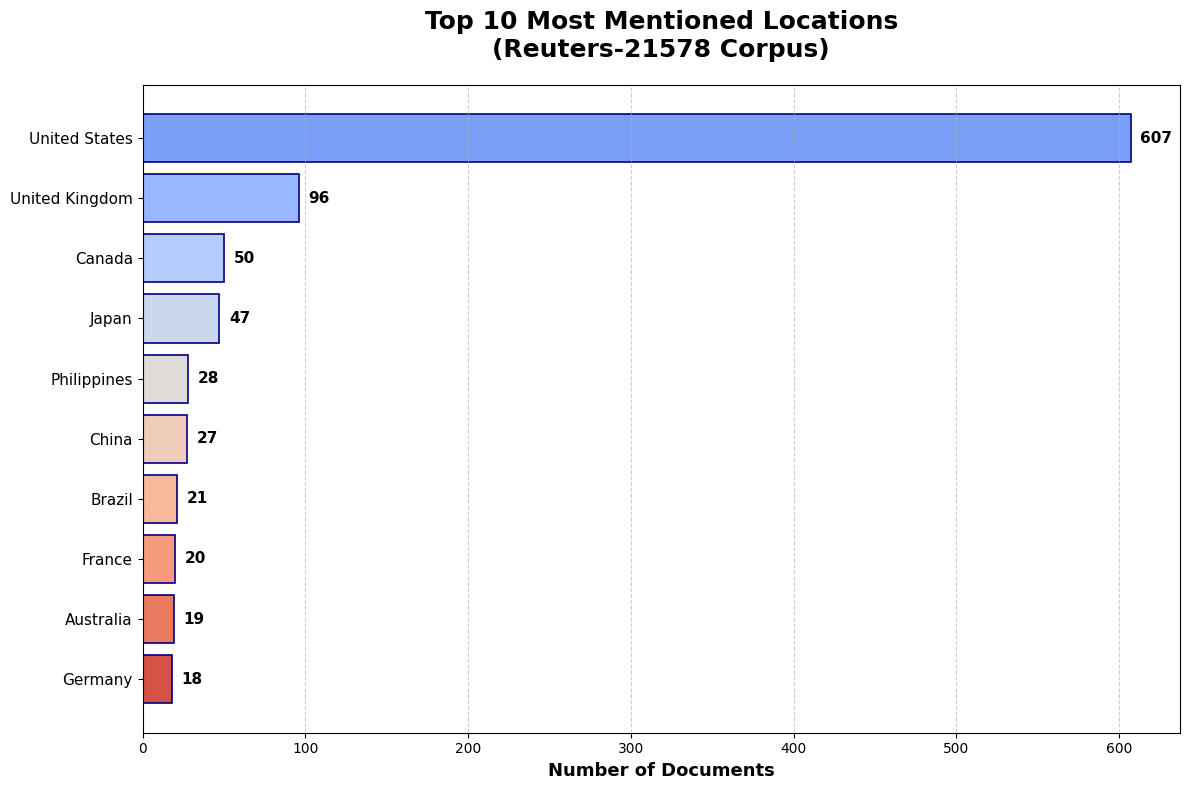

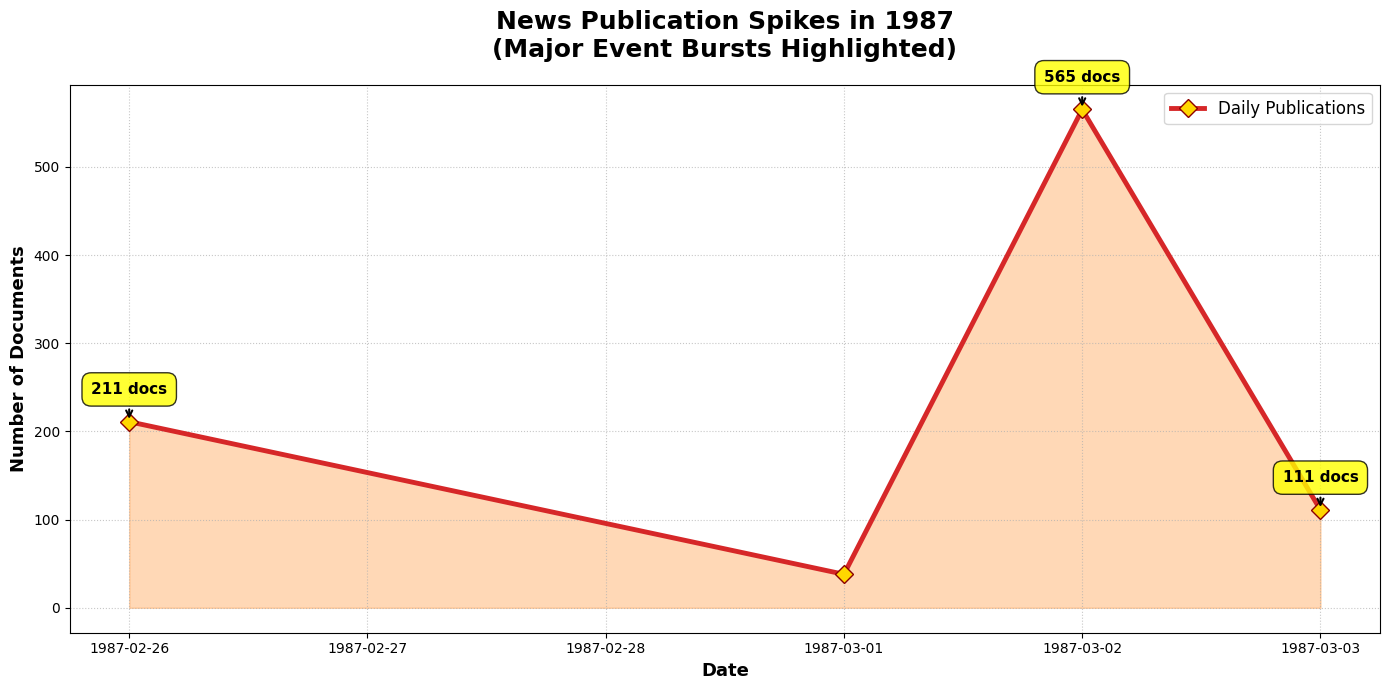

Visualizations saved as PNG files!
Fetching latest analytics from OpenSearch index...

Top Locations:
  • United States: 607 documents
  • United Kingdom: 96 documents
  • Canada: 50 documents
  • Japan: 47 documents
  • Philippines: 28 documents
  • China: 27 documents
  • Brazil: 21 documents
  • France: 20 documents
  • Australia: 19 documents
  • Germany: 18 documents

Active Publication Days:
  • 1987-02-26: 211 documents
  • 1987-03-01: 38 documents
  • 1987-03-02: 565 documents
  • 1987-03-03: 111 documents

Generating visualizations...


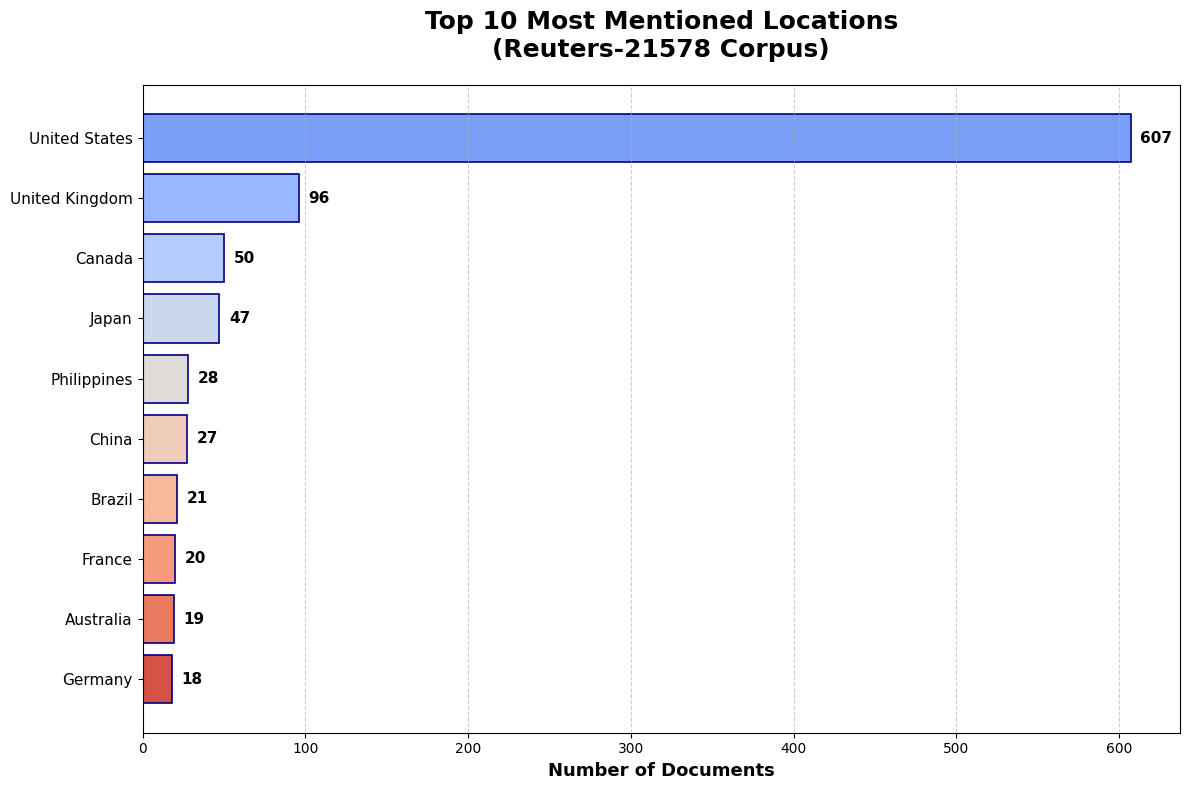

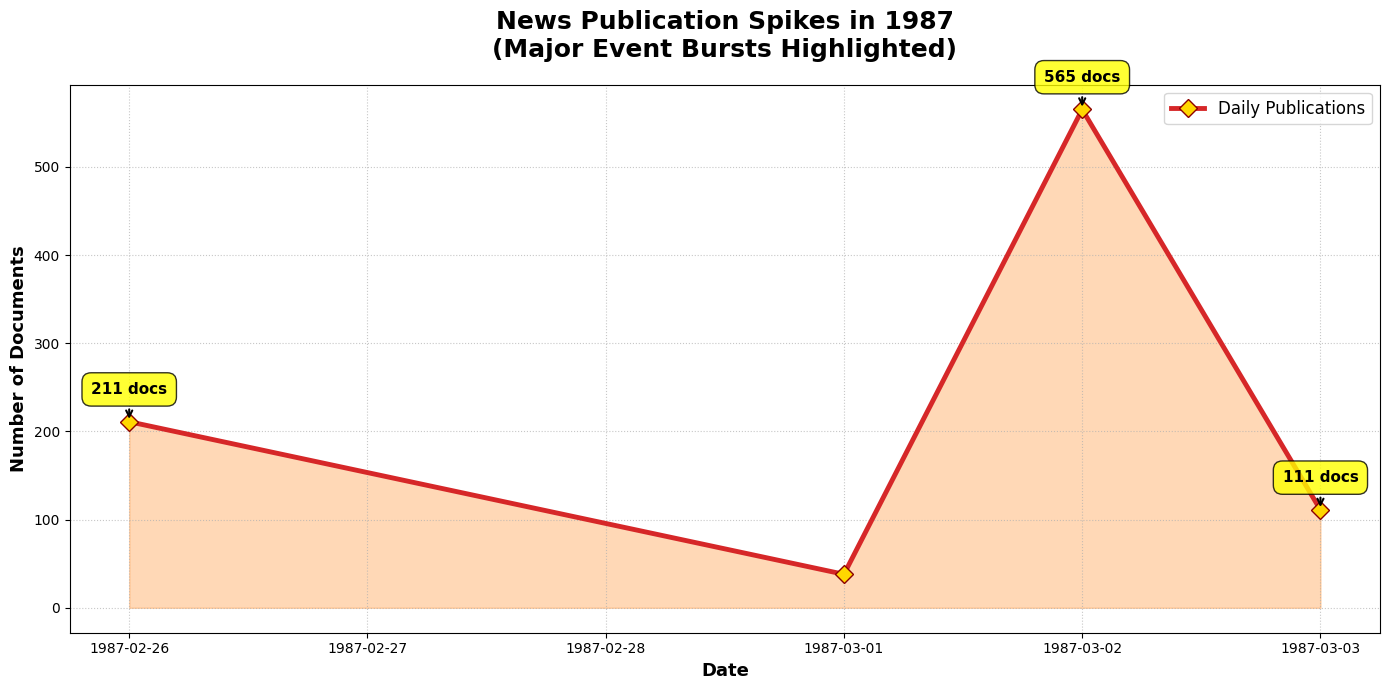

Visualizations saved as PNG files!


In [ ]:
# -------------------------

# -------------------------
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from opensearchpy import OpenSearch

# Connect to your OpenSearch (same as in your main code)
client = OpenSearch(
    hosts=[{"host": "localhost", "port": 9200}],
    http_compress=True,
    use_ssl=False,
    verify_certs=False
)

INDEX_NAME = "smart_docs"

def fetch_analytics_data(top_n=10):
    """Fetch top georeferences and daily timeline directly from the index"""
    body = {
        "size": 0,
        "query": {"match_all": {}},
        "aggs": {
            "top_places": {
                "terms": {
                    "field": "georeference_names",  
                    "size": top_n,
                    "order": {"_count": "desc"}
                }
            },
            "timeline": {
                "filter": {"exists": {"field": "date"}},
                "aggs": {
                    "by_day": {
                        "date_histogram": {
                            "field": "date",
                            "calendar_interval": "day",
                            "min_doc_count": 0,
                            "extended_bounds": {
                                "min": "1987-01-01",
                                "max": "1988-12-31"
                            },
                            "format": "yyyy-MM-dd"
                        }
                    }
                }
            }
        }
    }

    response = client.search(index=INDEX_NAME, body=body)

    # Extract top georeferences
    geo_buckets = response['aggregations']['top_places']['buckets']
    geo_data = [(bucket['key'], bucket['doc_count']) for bucket in geo_buckets]

    # Extract daily data (only days with documents)
    daily_buckets = response['aggregations']['timeline']['by_day']['buckets']
    daily_data = {}
    for bucket in daily_buckets:
        if bucket['doc_count'] > 0:
            daily_data[bucket['key_as_string']] = bucket['doc_count']

    return geo_data, daily_data

def visualize_analytics(geo_data, daily_data):
    # --- 1. Top Georeferences: Stylish Horizontal Bar Chart ---
    plt.figure(figsize=(12, 8))
    locations = [item[0] for item in geo_data]
    counts = [item[1] for item in geo_data]

    y_pos = np.arange(len(locations))
    # Creative gradient: from deep blue to light cyan
    colors = plt.cm.coolwarm(np.linspace(0.2, 0.9, len(locations)))

    bars = plt.barh(y_pos, counts, color=colors, edgecolor='navy', linewidth=1.2)
    plt.yticks(y_pos, locations, fontsize=11)
    plt.xlabel('Number of Documents', fontsize=13, fontweight='bold')
    plt.title('Top 10 Most Mentioned Locations\n(Reuters-21578 Corpus)', 
              fontsize=18, fontweight='bold', pad=20)

    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.6)

    # Add count labels on bars
    for bar in bars:
        width = int(bar.get_width())
        plt.text(width + max(counts)*0.01, bar.get_y() + bar.get_height()/2,
                 f'{width}', va='center', ha='left', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.savefig('top_10_georeferences_dynamic.png', dpi=300, bbox_inches='tight')
    plt.show()

    # --- 2. Daily Document Spikes: Creative Annotated Line Chart ---
    if not daily_data:
        print("No dated documents found for timeline visualization.")
        return

    plt.figure(figsize=(14, 7))
    dates_str = sorted(daily_data.keys())
    dates = [datetime.strptime(d, '%Y-%m-%d') for d in dates_str]
    counts_daily = [daily_data[d] for d in dates_str]

    plt.plot(dates, counts_daily, marker='D', markersize=9, linewidth=3.5,
             color='#d62728', label='Daily Publications', markerfacecolor='gold', markeredgecolor='darkred')
    plt.fill_between(dates, counts_daily, color='#ff7f0e', alpha=0.3)

    plt.xlabel('Date', fontsize=13, fontweight='bold')
    plt.ylabel('Number of Documents', fontsize=13, fontweight='bold')
    plt.title('News Publication Spikes in 1987\n(Major Event Bursts Highlighted)', 
              fontsize=18, fontweight='bold', pad=20)
    plt.grid(True, linestyle=':', alpha=0.7)

    # Creative annotations with callouts
    for date, count in zip(dates, counts_daily):
        if count > 100:  # Highlight major spikes
            plt.annotate(f'{count} docs',
                         (date, count),
                         textcoords="offset points",
                         xytext=(0, 20),
                         ha='center',
                         fontsize=11,
                         fontweight='bold',
                         bbox=dict(boxstyle="round,pad=0.6", facecolor="yellow", alpha=0.8),
                         arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig('daily_spikes_1987_dynamic.png', dpi=300, bbox_inches='tight')
    plt.show()

# -------------------------
# Run visualization using live data from OpenSearch
# -------------------------
if __name__ == "__main__":
    print("ANALYTICS: Top Locations & Active Publication Days")
    print("=" * 60)

    geo_data, daily_data = fetch_analytics_data(top_n=10)

    # Top locations
    print("Top 10 mentioned locations:")
    print("-" * 40)
    for i, (loc, cnt) in enumerate(geo_data, 1):
        print(f"{i:2}. {loc:<25} {cnt:>5} docs")

    # Active publication days
    print("\nActive publication days (1987):")
    print("-" * 40)
    for date, cnt in sorted(daily_data.items()):
        print(f"{date} : {cnt} documents")

    print("\nGenerating visualizations...")
    visualize_analytics(geo_data, daily_data)
    print("Visualizations saved as PNG files!")
    print("Fetching latest analytics from OpenSearch index...")
    geo_data, daily_data = fetch_analytics_data(top_n=10)

    print("\nTop Locations:")
    for loc, cnt in geo_data:
        print(f"  • {loc}: {cnt} documents")

    print("\nActive Publication Days:")
    for date, cnt in sorted(daily_data.items()):
        print(f"  • {date}: {cnt} documents")

    print("\nGenerating visualizations...")
    visualize_analytics(geo_data, daily_data)
    print("Visualizations saved as PNG files!")

In [ ]:
def pretty_print_search_results(result, show_rank=True, show_score=False):
    """
    Pretty-prints the results from smart_hybrid_search or any ES response.
    
    Parameters:
        result: The dict returned by client.search() or smart_hybrid_search()
                Expected structure: result["hits"]["hits"] list
        show_rank: Whether to show the ranking number (1., 2., etc.)
        show_score: Whether to show the Elasticsearch _score (useful for debugging)
    """
    hits = result.get("hits", {}).get("hits", [])
    
    if not hits:
        print("No results found.")
        return
    
    print(f"Found {len(hits)} matching document(s):\n")
    print("=" * 80)
    
    for i, hit in enumerate(hits, 1):
        source = hit["_source"]
        
        rank = f"{i:2}. " if show_rank else ""
        score = f" (score: {hit['_score']:.3f})" if show_score else ""
        
        title = source.get("title", "").strip()
        if not title:
            title = "<No title>"
        
        date = source.get("date", None)
        if date:
            # Clean up ISO format for readability
            try:
                date = datetime.fromisoformat(date.replace("Z", "+00:00").split('+')[0])
                date_str = date.strftime("%B %d, %Y")
            except:
                date_str = date
        else:
            date_str = "<No date>"
        
        georefs = source.get("georeference_names", [])
        if "UNKNOWN" in georefs and len(georefs) == 1:
            georef_str = "<No georeference>"
        else:
            georef_str = ", ".join(sorted(georefs))
        
        print(f"{rank}{title}")
        print(f"    Date        : {date_str}")
        print(f"    Locations   : {georef_str}{score}")
        print("-" * 80)

In [ ]:

    # === Your query ===
query_text = "oil price"
start_date_input = "1987-02-01"
end_date_input = "1987-06-30"
georef = "USA-centered"          
requested_size = 10

result = smart_hybrid_search(
        (query_text, start_date_input, end_date_input, georef),
        size=requested_size
    )

pretty_print_search_results(result, show_rank=True, show_score=True)

Found 10 matching document(s):

 1. EXXON <XON> CUTS HEATING OIL BARGE PRICE
    Date        : March 02, 1987
    Locations   : United States (score: 24.186)
--------------------------------------------------------------------------------
 2. UNOCAL <UCL> UNIT CUTS CRUDE OIL POSTED PRICES
    Date        : March 02, 1987
    Locations   : United States (score: 23.574)
--------------------------------------------------------------------------------
 3. IRISH OIL CONCERN HAS 8.5 PCT OF CYNERGY <CRG>
    Date        : March 02, 1987
    Locations   : United States (score: 11.402)
--------------------------------------------------------------------------------
 4. STANDARD OIL <SRD> TO ISSUE SWISS FRANC NOTE
    Date        : March 02, 1987
    Locations   : United States (score: 11.698)
--------------------------------------------------------------------------------
 5. HOUSTON OIL <HO> RESERVES STUDY COMPLETED
    Date        : February 26, 1987
    Locations   : United States (score: 12

# Print document by id

In [ ]:
def print_document_by_id(doc_id):
    """
    Prints a full document by its doc_id
    """
    try:
        res = client.get(index=INDEX_NAME, id=doc_id)
        source = res['_source']

        print(f"\n=== Document ID: {doc_id} ===\n")
        print(f"Title:\n{source.get('title', '')}\n")
        print(f"Content:\n{source.get('text', '')}\n")
        print(f"Authors: {source.get('authors')}")
        print(f"Date: {source.get('date')}")
        print(f"Extracted Georeference Names: {source.get('georeference_names')}")
        print(f"Main Geopoint: {source.get('geopoint')}")
        print(f"Temporal Expressions: {source.get('temporal_expressions')}")
        print("=" * 60)

    except Exception as e:
        print(f"Document with ID {doc_id} not found or error: {e}")

#Example usage: change the number to any doc_id you want to see
print_document_by_id(178)  # Replace 45 with the ID you saw during indexing


=== Document ID: 178 ===

Title:
REPORT COULD BE FINAL BLOW FOR REGAN

Content:


Authors: [{'first_name': 'Sue', 'last_name': 'Baker', 'email': ''}]
Date: 1987-02-26T18:00:08.860000
Extracted Georeference Names: ['United States']
Main Geopoint: {'lat': 39.7837304, 'lon': -100.445882}
Temporal Expressions: ['1986-02-26T00:00:00']
